In [1]:
### Utenti Validi
# '2c938084683d9f87016d1636f55a00de': (u'Grazia Benedetti',True,"24.10.19","1.4.20")
# '2c938084683d9f87016ff0d54c3d0138': (u'Maria Luisa  Bortoluzzi',True,"29.1.20","1.5.20")
# '2c938084683d9f87016fd2ac0d240134': (u'Silvia Francescangeli',True,"23.1.20","1.5.20")
# '2c938084683d9f87016cd1cbb80100a7': (u'Enrico Vottero',True,"30.09.19","20.12.19")
# '2c938084683d9f87016d163666b900db': (u'Giorgio Bertolani',True,"9.10.19","20.12.19")}

### Setup delle librerie e connessione al database

In [2]:
import pymongo 
from pymongo import MongoClient
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

import pickle

In [3]:
### connect to the db 
myclient = pymongo.MongoClient("mongodb://localhost:27018/")
mydb = myclient["mls"]
mycol = mydb["mqttlogs"]

### select a user and find all the respective entries
utente='2c938084683d9f87016d163666b900db'
print("PROCESSING USER:\n" + utente)

query = {'userid':utente}
db_entries = mycol.find(query)

PROCESSING USER:
2c938084683d9f87016d163666b900db


### Recupero di interventions e acks

In [4]:
ordered_interventions_id = []
interventions = dict()
acks = dict()

escape_interventions = ["641056j1-0g78-vjqf-cpju-7dnx895011y9"]

In [5]:
print("loading for interventions and acks from file")
data_file = open("./data_interventions_"+str(utente)+".pkl", "rb")
ordered_interventions_id,interventions,acks,dangling_interventions,times = pickle.load(data_file)
data_file.close()

loading for interventions and acks from file


### Recupero delle run

In [6]:
print("loading runs from file")
data_file = open("./run_fullcomunication_"+str(utente)+".pkl", "rb")
run = pickle.load(data_file)
data_file.close()

loading runs from file


### Recupero e print delle interventions con room-list

In [7]:
print("start loading for interventions with rooms indications")
data_file = open("./roomlist_interventions_"+str(utente)+".pkl", "rb")
intv_rooms = pickle.load(data_file)
data_file.close()

start loading for interventions with rooms indications


In [8]:
len(intv_rooms)

prec_list = []
current_list = []

for i in intv_rooms :
    current_list = intv_rooms[i]['raw_payload']['data']['rooms']
    if current_list != [] and current_list != prec_list :
        print(current_list)
    prec_list = current_list

['HALLWAY1', 'LIVINGROOM1', 'BEDROOM1', 'BEDROOM2', 'KITCHEN1', 'BATHROOM1']


### Estrazione di coordinate e informazioni (tempo, topological place, intervention id)

In [9]:
coordinates = []
x = []
y = []
t = []
tp = []
ii = []

for r in run :
    x = []
    y = []
    t = []
    tp = []
    ii = []
    for i in range(len(r)) : 
        s = r[i]['raw_payload']['data']['pose']
        tplace = r[i]['raw_payload']['data']['topological_place']
        if s !='[]' : # and tplace != 'NOT_AVAILABLE'
            a = list(map(float,s[1:-1].split(" ")))
            x.append(a[0])
            y.append(a[1])
            t.append(r[i]['raw_payload']['time']['t'])
            tp.append(tplace)
            ii.append(r[i]['intervention_id'])
    coordinates.append([x,y,t,tp,ii])

len(coordinates)

347

### Filtraggio delle run con teleport

In [10]:
filtered_coordinates = []

for x,y,t,tp,ii in coordinates : 
    tpp = []
    current_run_x = []
    current_run_y = []
    last_x = x[0]
    last_y = y[0]
    Tflag = False
    for i,j in zip(x,y) : 
        current_run_x.append(i)
        current_run_y.append(j)
        tmp  = math.sqrt(pow(i-last_x,2)+pow(j-last_y,2))
        if tmp >= 0.75 :
            Tflag = True
            tpp.append([last_x,last_y,i,j])
        last_x = i
        last_y = j
    if Tflag == True : 
        filtered_coordinates.append([current_run_x,current_run_y,t,tp,ii,tpp])

len(filtered_coordinates)

6

In [11]:
print("valid filtered-runs with no topological place indications")
num = 0
for x,y,t,tp,ii,tpp in filtered_coordinates : 
    if 'NOT_AVAILABLE' in tp :
        print("run "+str(num))
    num += 1

valid filtered-runs with no topological place indications
run 0
run 1


### Plot delle run con teleport

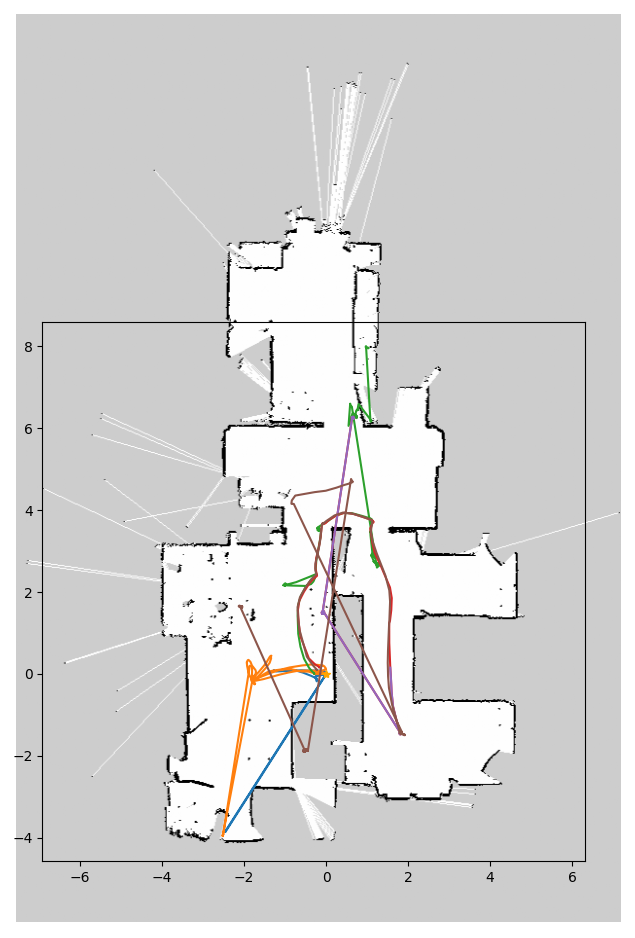

In [21]:
img = plt.imread("./mapsIT/"+str(utente)+".png")
fig, ax = plt.subplots(figsize = (7,7))

imagebox = OffsetImage(img, zoom = 0.7, cmap = 'gist_gray')
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, (-0.2,5), xycoords = 'data', bboxprops ={'lw':0}, zorder = 0)
ax.add_artist(ab)

for x,y,t,tp,ii,tpp in filtered_coordinates : 
    plt.plot(x,y)

plt.plot(0,0,'*', color = 'orange')
ax.axis('equal')
# ax.axis('off')
fig.savefig("./trajectories/filtered/"+utente+"_filtered_onMap.pdf", bbox_inches = 'tight')

[-0.002, -0.002, -2.468, -3.856]

[-1.781, -0.067, -2.521, -3.951]

[1.24, 2.592, 0.628, 6.521]

[1.807, -1.433, -0.053, 1.501]

[1.807, -1.433, -0.053, 1.501]

[1.847, -1.418, -0.789, 4.145]



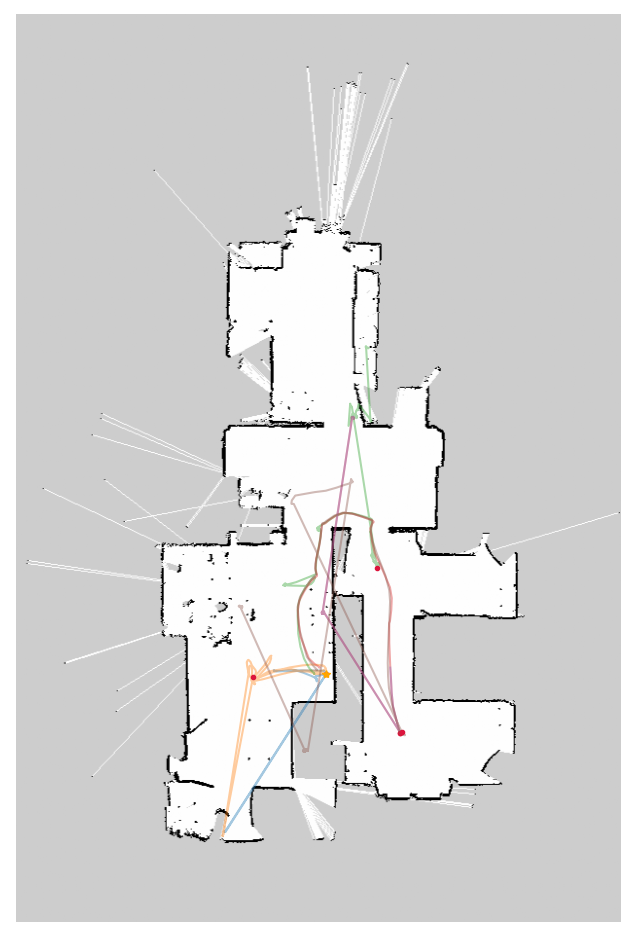

In [22]:
img = plt.imread("./mapsIT/"+str(utente)+".png")
fig, ax = plt.subplots(figsize = (7,7))

imagebox = OffsetImage(img, zoom = 0.7, cmap = 'gist_gray')
imagebox.image.axes = ax
ab = AnnotationBbox(imagebox, (-0.2,5), xycoords = 'data', bboxprops ={'lw':0}, zorder = 0)
ax.add_artist(ab)

for x,y,t,tp,ii,tpp in filtered_coordinates : 
    plt.plot(x,y,alpha=0.4)
    print(tpp[0])
    print("")
    plt.plot(tpp[0][0],tpp[0][1],'.',c = 'crimson') 
    # THIS PRINTS ALL THE TPP
    # for x1,y1,x2,y2 in tpp :
    #     plt.plot(x1,y1,'.',c = 'crimson')

plt.plot(0,0,'*', color = 'orange')
plt.axis('equal')
ax.axis('off')
plt.show()
fig.savefig("./trajectories/distributions/"+utente+"_tpp_distribution_onMap.pdf", bbox_inches = 'tight')

### Plot di coordinate e informazioni di una singola run

RUN NUMERO 0

intervention-id corrispondenti: 
4c2e6b0b-fc66-406f-a4ad-c5ac9a6a0b79
57bf985c-3970-4670-b41a-83d554331d43

cambio di topological-place alle coordinate:
-2.468 -3.856 tra LIVINGROOM1 e NOT_AVAILABLE
0.004 -0.007 tra NOT_AVAILABLE e docking_station
-0.244 -0.06 tra docking_station e LIVINGROOM1
0.015 0.018 tra LIVINGROOM1 e docking_station


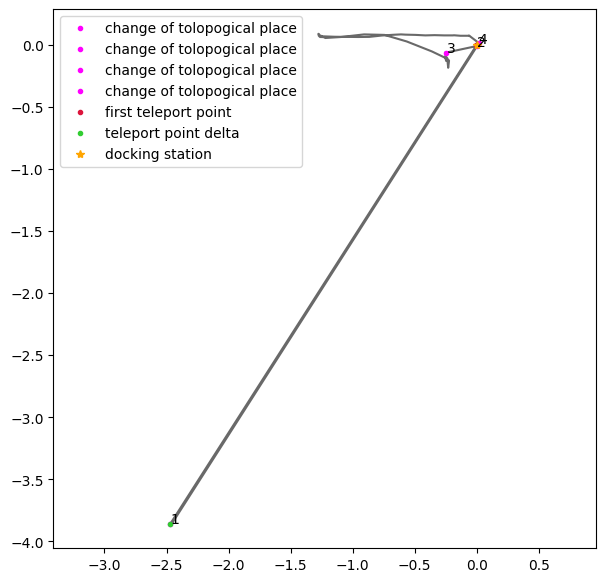

In [14]:
img = plt.imread("./mapsIT/"+str(utente)+".png")
fig, ax = plt.subplots(figsize = (7,7))

# imagebox = OffsetImage(img, zoom = 0.7, cmap = 'gist_gray')
# imagebox.image.axes = ax
# ab = AnnotationBbox(imagebox, (-3.4,2.3), xycoords = 'data', bboxprops ={'lw':0}, zorder = 0)
# ax.add_artist(ab)

run_count = 0
selected_run = 0
tp_num = 1
print("RUN NUMERO "+str(selected_run))


for x,y,t,tp,ii,tpp in filtered_coordinates : 
    if run_count == selected_run : 

        plt.plot(x,y, c = 'dimgray')

        # Print the corriesponding intervention-id
        print("\nintervention-id corrispondenti: ")
        print(ii[0])
        prec_id = ii[0]
        for z in ii : 
            if z != prec_id : 
                print(z)
            prec_id = z
        
        # Print and plot the topological place changes
        print("\ncambio di topological-place alle coordinate:")
        prec = tp[0]
        pose_number = 0
        for j in tp :
            if j != prec : 
                print(str(x[pose_number]), str(y[pose_number])+" tra "+prec+" e "+j)
                plt.plot(x[pose_number], y[pose_number], '.',c='magenta', label = 'change of tolopogical place')
                plt.text(x[pose_number], y[pose_number],str(tp_num))
                tp_num += 1
            prec = j
            pose_number += 1
        
        #Plot the first tpp of the selected run
        plt.plot(tpp[selected_run][0],tpp[selected_run][1],'.',c = 'crimson', label = 'first teleport point')
        plt.plot(tpp[selected_run][2],tpp[selected_run][3],'.',c = 'limegreen', label = 'teleport point delta')
    
    run_count += 1

# THIS PRINTS EVERY TPP OF THE SINGLE SELECTED RUN
# tpp_num = 1
# for x1,y1,x2,y2 in tpp :
#     plt.plot(x1,y1,'.',c = 'limegreen', label = 'point where teleport happen')
#     plt.plot(x2,y2,'.',c = 'crimson', label = 'teleport delta')
#     plt.text(x1,y1,tpp_num)
#     plt.text(x2,y2,tpp_num)
#     tpp_num += 1

ax.plot(0,0,'*', color = 'orange', label = 'docking station')
ax.axis('equal')
ax.legend() # da sistemare il cambio di tp
# ax.axis('off')
plt.show()